# CIFAR-10 Images Using PCA, SVM and Ensemble methods

## Libraries and packages

In [3]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import seaborn as sns
import pandas as pd 
from PIL import Image
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, roc_curve,auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.special import expit

## Loading the Data

In [5]:
data = load_dataset("uoft-cs/cifar10")
print(data)

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})


### Splitting into train and test parts

In [7]:
train_data = data['train']
test_data = data['test']

In [8]:
train_data.shape

(50000, 2)

In [9]:
train_data[0:1]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [0]}

### Label Dictionary

In [11]:
label_dict = {i: name for i, name in enumerate(train_data.features['label'].names)}
print(label_dict)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


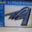

In [12]:
data['train'][2]['img']

In [13]:
img = train_data[0]['img']    
label = train_data[0]['label']  

img_array = np.array(img)       
img_array

array([[[178, 176, 189],
        [178, 176, 189],
        [178, 176, 189],
        ...,
        [170, 168, 180],
        [168, 166, 177],
        [165, 163, 174]],

       [[180, 178, 191],
        [179, 177, 190],
        [180, 178, 191],
        ...,
        [173, 171, 182],
        [171, 169, 180],
        [168, 166, 177]],

       [[177, 175, 188],
        [177, 175, 188],
        [178, 176, 189],
        ...,
        [171, 169, 180],
        [169, 167, 178],
        [167, 165, 176]],

       ...,

       [[112, 107, 107],
        [113, 109, 108],
        [114, 110, 110],
        ...,
        [100,  97,  94],
        [ 98,  94,  93],
        [101,  95,  95]],

       [[112, 102, 101],
        [112, 103, 102],
        [113, 103, 103],
        ...,
        [102,  95,  93],
        [102,  93,  91],
        [102,  92,  91]],

       [[103,  96,  92],
        [100,  93,  90],
        [103,  95,  94],
        ...,
        [ 92,  84,  80],
        [ 93,  86,  80],
        [ 91,  84,  77]]

### Preparing and cleaning data (preprocessing)

In [15]:
def prepare_dataset(dataset, n_samples):
    X, y = [], []
    for i in tqdm(range(n_samples)):
        img = np.array(dataset[i]['img']).flatten() 
        label = dataset[i]['label']
        X.append(img)
        y.append(label)
    return np.array(X), np.array(y)

## PCA

In [17]:
n_train = len(train_data) 
n_test = len(test_data)  

In [18]:
X_train, y_train = prepare_dataset(train_data, n_train)
X_test, y_test = prepare_dataset(test_data,n_test)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1036.26it/s]


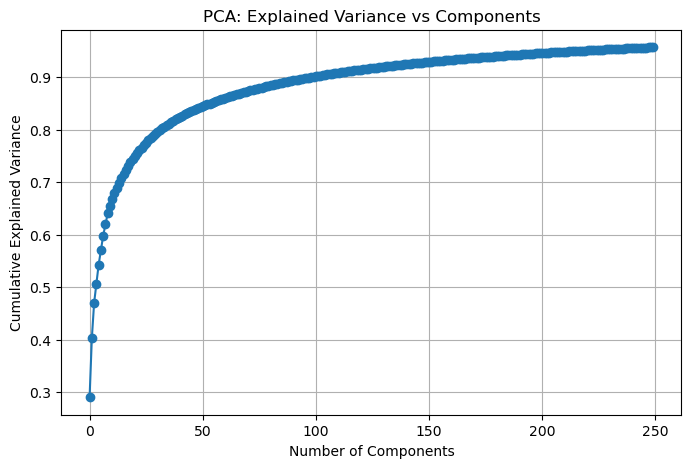

In [19]:
pca0 = PCA(n_components=250)
pca0.fit(X_train)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca0.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs Components')
plt.grid(True)
plt.show()

### Choosing an optimal number for PCA components

In [21]:
cumulative_variance = np.cumsum(pca0.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of components for 95% variance: {optimal_components}")

Optimal number of components for 95% variance: 217


In [22]:
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_test_pca.shape

(10000, 217)

## SVM

In [24]:
svm = SVC(kernel='rbf', probability=True, random_state=42)

batch_size = 1000
n_samples = X_train_pca.shape[0]

y_pred = []

for start_idx in range(0, n_samples, batch_size):
    end_idx = min(start_idx + batch_size, n_samples)
    X_batch = X_train_pca[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]
    
    svm.fit(X_batch, y_batch)  

y_pred = svm.predict(X_test_pca)

y_prob = svm.predict_proba(X_test_pca)

### Confusion matrix (SVM)

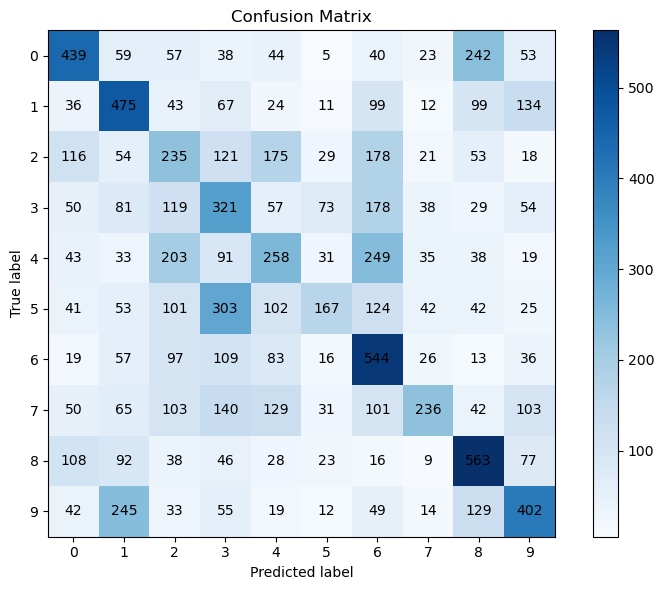

In [26]:
conf_matrix_svm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_svm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = np.unique(y_test)
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f'{conf_matrix_svm[i, j]}', ha='center', va='center', color='black')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


### Metrics for the SVM model

In [28]:
accuracy_svm = accuracy_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred, average='weighted')
recall_svm = recall_score(y_test, y_pred, average='weighted')
balanced_accuracy_svm = balanced_accuracy_score(y_test, y_pred)

y_test_bin_svm = label_binarize(y_test, classes=np.unique(y_test))
roc_auc_svm = roc_auc_score(y_test_bin_svm, y_prob, average='weighted', multi_class='ovr')


print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision (Weighted): {precision_svm:.4f}")
print(f"Recall (Weighted): {recall_svm:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_svm:.4f}")
print(f"ROC AUC Score: {roc_auc_svm:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.3640
Precision (Weighted): 0.3783
Recall (Weighted): 0.3640
Balanced Accuracy: 0.3640
ROC AUC Score: 0.8072

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.44      0.45      1000
           1       0.39      0.47      0.43      1000
           2       0.23      0.23      0.23      1000
           3       0.25      0.32      0.28      1000
           4       0.28      0.26      0.27      1000
           5       0.42      0.17      0.24      1000
           6       0.34      0.54      0.42      1000
           7       0.52      0.24      0.32      1000
           8       0.45      0.56      0.50      1000
           9       0.44      0.40      0.42      1000

    accuracy                           0.36     10000
   macro avg       0.38      0.36      0.36     10000
weighted avg       0.38      0.36      0.36     10000



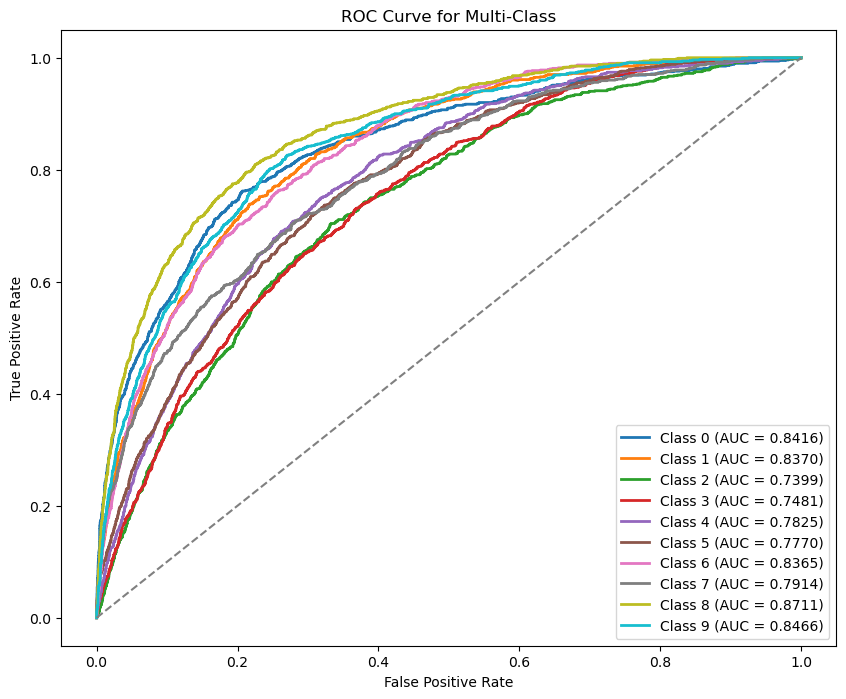

In [29]:
classes = np.unique(y_test)

y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class')
plt.legend(loc='lower right')
plt.show()


## XGBoost Model with HOG Feature Extraction

In [31]:
X_train_xgb, y_train_xgb = X_train, y_train
X_test_xgb, y_test_xgb = X_test, y_test

In [32]:
X_train_sub_xgb, X_val_xgb, y_train_sub_xgb, y_val_xgb = train_test_split(X_train_xgb, y_train_xgb, test_size=0.2, random_state=42)

In [33]:
from skimage.feature import hog

data = load_dataset("uoft-cs/cifar10")
train_data, test_data = data['train'], data['test']

def extract_hog_features(images, n_samples):
    hog_features = []
    for i in tqdm(range(n_samples)):
        img = np.array(images[i]['img'])
        gray_img = np.mean(img, axis=2)
        features = hog(
            gray_img,
            pixels_per_cell=(8, 8), 
            cells_per_block=(2, 2),
            orientations=9,
            block_norm='L2-Hys'
        )
        hog_features.append(features)
    return np.array(hog_features)

n_train = 50000
n_test = 10000

X_train_hog = extract_hog_features(train_data, n_train)
X_test_hog = extract_hog_features(test_data, n_test)
y_train = np.array([train_data[i]['label'] for i in range(n_train)])
y_test = np.array([test_data[i]['label'] for i in range(n_test)])

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_hog, y_train, test_size=0.2, random_state=42
)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 609.28it/s]


### Confusion matrix (XGB)

In [35]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=10,
    eval_metric='mlogloss',
    tree_method='hist',  
    max_depth=6, 
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)

xgb_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    verbose=1
)

[0]	validation_0-mlogloss:2.23733
[1]	validation_0-mlogloss:2.18127
[2]	validation_0-mlogloss:2.13371
[3]	validation_0-mlogloss:2.09073
[4]	validation_0-mlogloss:2.05060
[5]	validation_0-mlogloss:2.01474
[6]	validation_0-mlogloss:1.98175
[7]	validation_0-mlogloss:1.95111
[8]	validation_0-mlogloss:1.92272
[9]	validation_0-mlogloss:1.89640
[10]	validation_0-mlogloss:1.87196
[11]	validation_0-mlogloss:1.84930
[12]	validation_0-mlogloss:1.82693
[13]	validation_0-mlogloss:1.80674
[14]	validation_0-mlogloss:1.78759
[15]	validation_0-mlogloss:1.76948
[16]	validation_0-mlogloss:1.75240
[17]	validation_0-mlogloss:1.73636
[18]	validation_0-mlogloss:1.72091
[19]	validation_0-mlogloss:1.70653
[20]	validation_0-mlogloss:1.69305
[21]	validation_0-mlogloss:1.67983
[22]	validation_0-mlogloss:1.66680
[23]	validation_0-mlogloss:1.65497
[24]	validation_0-mlogloss:1.64309
[25]	validation_0-mlogloss:1.63201
[26]	validation_0-mlogloss:1.62158
[27]	validation_0-mlogloss:1.61187
[28]	validation_0-mlogloss:1.6

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1, num_class=10, ...)

              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1000
           1       0.66      0.68      0.67      1000
           2       0.49      0.41      0.45      1000
           3       0.41      0.35      0.38      1000
           4       0.47      0.52      0.49      1000
           5       0.46      0.46      0.46      1000
           6       0.56      0.68      0.61      1000
           7       0.63      0.57      0.60      1000
           8       0.61      0.62      0.62      1000
           9       0.65      0.68      0.66      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



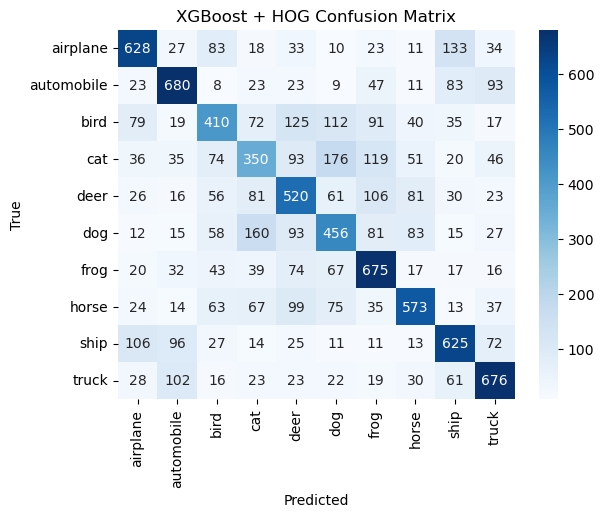

In [62]:
y_pred = xgb_model.predict(X_test_hog)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_dict.values(),
            yticklabels=label_dict.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost + HOG Confusion Matrix')
plt.show()

### Metrics for XGBoost model

In [38]:
accuracy_xgb = accuracy_score(y_test_xgb[:n_test], y_pred)
print(f"Accuracy (XGBoost): {accuracy_xgb:.4f}")

precision_xgb = precision_score(y_test_xgb[:n_test], y_pred, average='weighted')
recall_xgb = recall_score(y_test_xgb[:n_test], y_pred, average='weighted')
balanced_acc_xgb = balanced_accuracy_score(y_test_xgb[:n_test], y_pred)

print(f"Precision (weighted) (XGBoost): {precision_xgb:.4f}")
print(f"Recall (weighted) (XGBoost): {recall_xgb:.4f}")
print(f"Balanced Accuracy (XGBoost): {balanced_acc_xgb:.4f}")


y_test_bin_xgb = label_binarize(y_test_xgb[:n_test], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_prob_xgb = xgb_model.predict_proba(X_test_hog[:n_test])

roc_auc_xgb = roc_auc_score(y_test_bin_xgb, y_pred_prob_xgb, multi_class='ovr')
print(f"ROC AUC Score (XGBoost): {roc_auc_xgb:.4f}")

Accuracy (XGBoost): 0.5593
Precision (weighted) (XGBoost): 0.5568
Recall (weighted) (XGBoost): 0.5593
Balanced Accuracy (XGBoost): 0.5593
ROC AUC Score (XGBoost): 0.9043


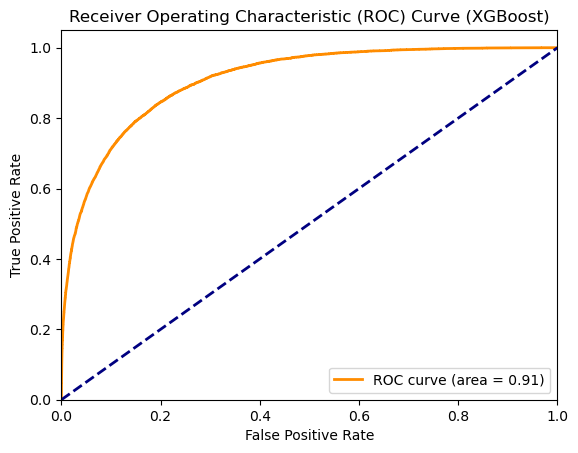

In [39]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test_bin_xgb.ravel(), y_pred_prob_xgb.ravel())
roc_auc_curve_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_curve_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (XGBoost)')
plt.legend(loc='lower right')
plt.show()

## Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [50]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [51]:
y_pred_rf = rf_model.predict(X_test_pca)
y_prob_rf = rf_model.predict_proba(X_test_pca)
y_test_bin_rf = label_binarize(y_test, classes=np.unique(y_test))

In [55]:
accuracy = accuracy_score(y_test, y_pred_rf)
precision_weighted = precision_score(y_test, y_pred_rf, average='weighted')
recall_weighted = recall_score(y_test, y_pred_rf, average='weighted')
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test_bin_rf, y_prob_rf, multi_class='ovr')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision_weighted * 100:.2f}%")
print(f"Recall (Weighted): {recall_weighted * 100:.2f}%")
print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc * 100:.2f}%")

Accuracy: 43.91%
Precision (Weighted): 43.46%
Recall (Weighted): 43.91%
Balanced Accuracy: 43.91%
ROC AUC Score: 83.25%


### Confusion Matrix (RF)

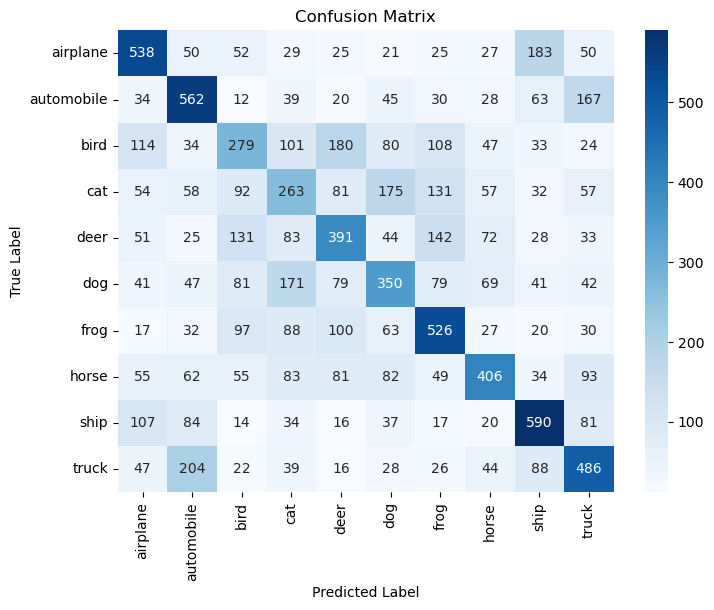

In [58]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))


sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_dict.values(),
            yticklabels=label_dict.values())

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Metrics for Random Forest Model

In [64]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
balanced_accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_bin_rf, y_prob_rf, average='weighted', multi_class='ovr')


print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Precision: {precision_rf:.4f}")
print(f"Random Forest Recall: {recall_rf:.4f}")
print(f"Random Forest Balanced Accuracy: {balanced_accuracy_rf:.4f}")
print(f"Random Forest ROC AUC Score: {roc_auc_rf:.4f}")


Random Forest Accuracy: 0.4391
Random Forest Precision: 0.4346
Random Forest Recall: 0.4391
Random Forest Balanced Accuracy: 0.4391
Random Forest ROC AUC Score: 0.8325


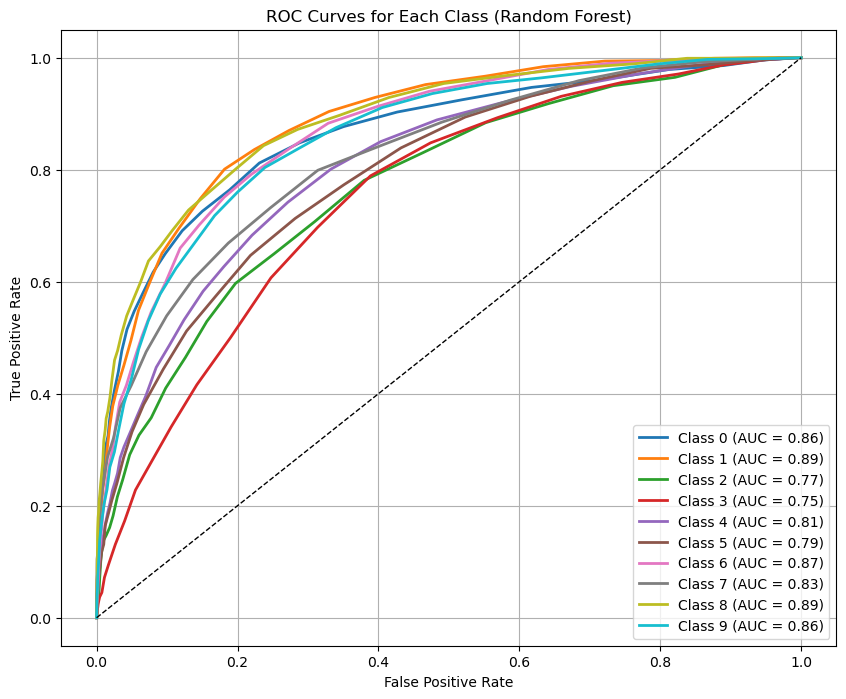

In [66]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class (Random Forest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Choosing the best model

In [69]:
metrics_dict = {
    'Model': ['SVM', 'XGBoost', 'Random Forest'],
    'Accuracy': [accuracy_svm, accuracy_xgb, accuracy_rf],
    'Precision (Weighted)': [precision_svm, precision_xgb, precision_rf],
    'Recall (Weighted)': [recall_svm, recall_xgb, recall_rf],
    'Balanced Accuracy': [balanced_accuracy_svm, balanced_acc_xgb, balanced_accuracy_rf],
    'ROC AUC Score': [roc_auc_svm, roc_auc_xgb, roc_auc_rf]
}


metrics_df = pd.DataFrame(metrics_dict)


print(metrics_df)

           Model  Accuracy  Precision (Weighted)  Recall (Weighted)  \
0            SVM    0.3640              0.378284             0.3640   
1        XGBoost    0.5593              0.556804             0.5593   
2  Random Forest    0.4391              0.434592             0.4391   

   Balanced Accuracy  ROC AUC Score  
0             0.3640       0.807180  
1             0.5593       0.904266  
2             0.4391       0.832488  


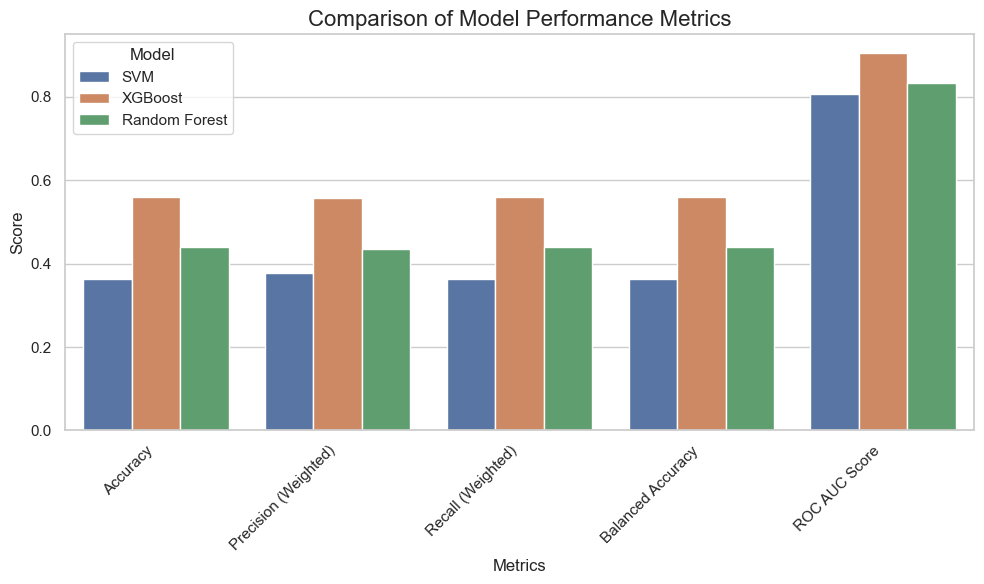

In [71]:
plt.figure(figsize=(10, 6))

sns.set(style="whitegrid")

metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_df_melted)

plt.xticks(rotation=45, ha='right')

plt.title('Comparison of Model Performance Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.tight_layout()
plt.show()


In [73]:
metrics_df.to_csv("model_performance_metrics.csv", index=False)

print("Saved model performance metrics to 'model_performance_metrics.csv'")


Saved model performance metrics to 'model_performance_metrics.csv'


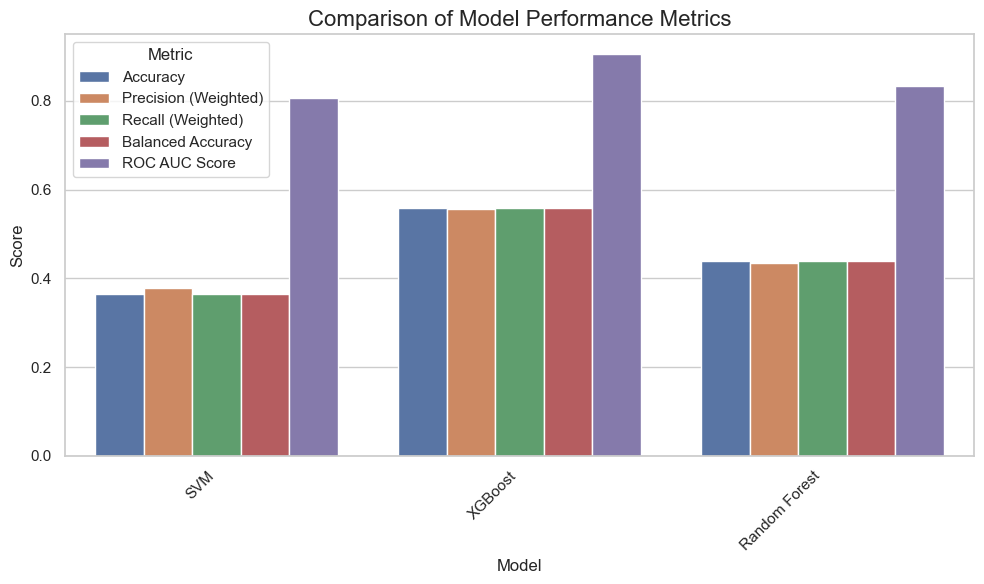

In [75]:
plt.figure(figsize=(10, 6))

sns.set(style="whitegrid")

metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df_melted)

plt.xticks(rotation=45, ha='right')

plt.title('Comparison of Model Performance Metrics', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.tight_layout()
plt.show()


In [77]:
pd.read_csv("model_performance_metrics.csv")

,Model,Accuracy,Precision (Weighted),Recall (Weighted),Balanced Accuracy,ROC AUC Score
0,SVM,0.3640,0.378284,0.3640,0.3640,0.807180
1,XGBoost,0.5593,0.556804,0.5593,0.5593,0.904266
2,Random Forest,0.4391,0.434592,0.4391,0.4391,0.832488
